In [1]:
# JSS
## TODO 
#using pca to reduce the dimensionality of the global descriptors
#using MobileVnet instead of netVLAD

#understand what superglue is outputting
# getting two models from SFM 
# Setting up the scale of the model -- this is done easy and simple
import numpy as np
import argparse
import yaml
import logging
from pathlib import Path
from tqdm import tqdm
from pprint import pformat
import h5py
import json
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from shutil import copyfile
import os
import sys
import collections
import struct
import argparse
# from notebooks.utils import plot_images, plot_matches, add_frame

from hfnet.models import get_model  
import Image_functions
import  jsonparser
from hloc.utils import viz
from hloc import  visualization

In [2]:
# send the path to the image directory and get the path to all the images in it
def image_directory_parser(path, viewer=True, number= 4):    
    globs=['*.jpg', '*.png', '*.jpeg', '*.JPG', '*.PNG']
    ## can also use sufix instead of with method
    image_path = []
    for g in globs:
        image_path += list(path.glob("**/"+g))
    if viewer:
        nrows = number
        ncols = number
        fig = plt.gcf()
        fig.set_size_inches(ncols*4, ncols*4)
        for i in range(2*number):
            sp = plt.subplot(nrows, ncols, i + 1)
            sp.axis('Off') # Don't show axes (or gridlines)
            img = mpimg.imread((image_path[i]))
            plt.imshow(img)
        plt.show()
    return image_path
# image dictionary creator gives image, its name and index as dictionary
def dictionary_of_images(image_path):
    image_dict ={}
    for i,j in tqdm(enumerate(image_path)):
        image_array = cv2.imread(str(j))
#         print(image_path[i].name)
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_dict[i] = {"image":image_array, "name": image_path[i].name, "number": i}
    return image_dict

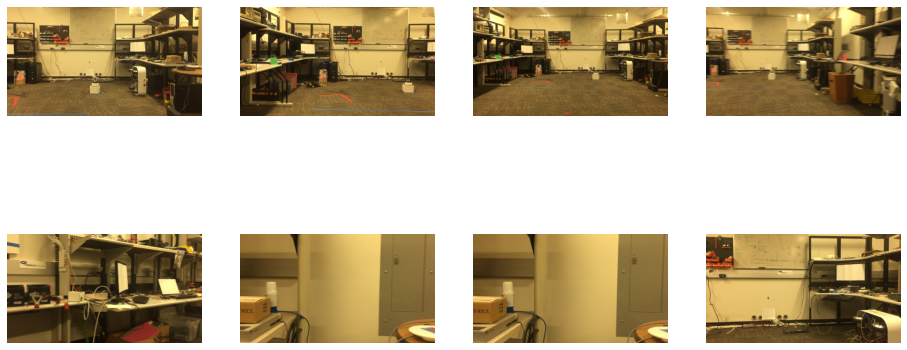

1637it [00:18, 88.75it/s]

1637


In [3]:
## image path will have path to all the images in it
## This will show 8 images 
path_to_images_for_map = Path("/home/Hierarchical-Localization/datasets/UsefulImagesT3")
image_path = image_directory_parser(path_to_images_for_map, viewer=True, number = 4)
image_dict = dictionary_of_images(image_path)
print(len(image_dict))

In [4]:
# this finds the global matrix and create the h5 file for global features
# also return a dictionary with index, image name and the descriptor associated
def global_dict_matrix_and_H5_map(config, image_dict):
    predictions_dict = {}
    global_feature_path = (config["output"])/"global_features.h5"
    global_feature_file = h5py.File(str(global_feature_path), 'w')
    checkpoint_path = Path(config["checkpoint_path"])
    keys = ['global_descriptor']    
    with get_model(config['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path))
        for i in tqdm(range(len(image_dict))):
            data = image_dict[i] ## selecting using index
            predictions = net.predict(data, keys=keys)
            predictions_dict[i] = {"global_descriptor":predictions['global_descriptor'], "name" : data['name']}   
            if i == 0:
                global_matrix = np.array(predictions['global_descriptor'])
            else:
                global_matrix = np.vstack((global_matrix,predictions['global_descriptor']))
            grp = global_feature_file.create_group(data['name'])
            grp.create_dataset('global_descriptor', data=predictions['global_descriptor'])
        global_feature_file.close()
    return predictions_dict, global_matrix

In [5]:
## here set the path for output 
#"""sfm_T3_pba""" 
output_path = Path("/home/Hierarchical-Localization/outputs/sfm_T3_pba")
output_path.mkdir(exist_ok =True, parents= True)
# here setting the path for weights saved for netVLAD
checkpoint_path = Path("/home/Hierarchical-Localization/weights/vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white")
# here config for global
config_global = {'output':output_path, 'checkpoint_path':checkpoint_path, 'data': {'name': 'aachen', 'load_db': False, 'load_queries': True, 'resize_max': 960}, 'model': {'name': 'netvlad_original', 'local_descriptor_layer': 'conv3_3', 'image_channels': 1}, 'weights': 'vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white'}         

In [6]:
# calling the function for global descriptor
global_dict_map, global_matrix = global_dict_matrix_and_H5_map(config_global, image_dict)

W0302 12:25:14.740985 139866521229120 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:104: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0302 12:25:14.756722 139866521229120 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0302 12:25:14.757925 139866521229120 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0302 12:25:14.760595 139866521229120 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:275: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0302 12:25:14.764078 139866521229120 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/h

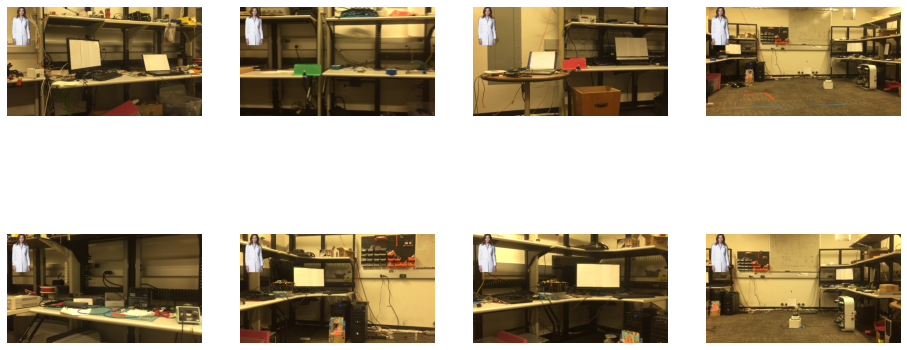

2104it [00:14, 142.13it/s]


In [8]:
## send the path to query images
path_to_query = Path("/home/Hierarchical-Localization/datasets/UsefulImagesT4_scale_0.35")
## this will create a list with all the image path in it
image_path_query = image_directory_parser(path_to_query, viewer=True, number = 4)
# dictionary_of_images creator gives image, its name and index as dictionary
image_dict_query = dictionary_of_images(image_path_query)

In [9]:
## will find the global descriptor for query images
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)
def global_dict_matrix_query(config, image_dict):
    predictions_dict = {}
    checkpoint_path = Path(config["checkpoint_path"])
    keys = ['global_descriptor']    
    with get_model(config['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path))
        for i in tqdm(range(len(image_dict))):
            data = image_dict[i] ## selecting using index
            predictions = net.predict(data, keys=keys)
            predictions_dict[i] = {"global_descriptor":predictions['global_descriptor'], "name" : data['name']}   
            if i == 0:
                global_matrix = np.array(predictions['global_descriptor'])
            else:
                global_matrix = np.vstack((global_matrix,predictions['global_descriptor']))
    return predictions_dict, global_matrix

In [10]:
# calling the above function 
predicitons_dict_query, global_matric_query = global_dict_matrix_query(config_global, image_dict_query)

I0302 12:27:21.191858 139866521229120 base_model.py:411] Restoring variables: 
	vgg16_netvlad_pca/WPCA/bias
	vgg16_netvlad_pca/WPCA/kernel
	vgg16_netvlad_pca/assignment/kernel
	vgg16_netvlad_pca/average_rgb
	vgg16_netvlad_pca/cluster_centers
	vgg16_netvlad_pca/conv1_1/bias
	vgg16_netvlad_pca/conv1_1/kernel
	vgg16_netvlad_pca/conv1_2/bias
	vgg16_netvlad_pca/conv1_2/kernel
	vgg16_netvlad_pca/conv2_1/bias
	vgg16_netvlad_pca/conv2_1/kernel
	vgg16_netvlad_pca/conv2_2/bias
	vgg16_netvlad_pca/conv2_2/kernel
	vgg16_netvlad_pca/conv3_1/bias
	vgg16_netvlad_pca/conv3_1/kernel
	vgg16_netvlad_pca/conv3_2/bias
	vgg16_netvlad_pca/conv3_2/kernel
	vgg16_netvlad_pca/conv3_3/bias
	vgg16_netvlad_pca/conv3_3/kernel
	vgg16_netvlad_pca/conv4_1/bias
	vgg16_netvlad_pca/conv4_1/kernel
	vgg16_netvlad_pca/conv4_2/bias
	vgg16_netvlad_pca/conv4_2/kernel
	vgg16_netvlad_pca/conv4_3/bias
	vgg16_netvlad_pca/conv4_3/kernel
	vgg16_netvlad_pca/conv5_1/bias
	vgg16_netvlad_pca/conv5_1/kernel
	vgg16_netvlad_pca/conv5_2/bias


In [11]:
## creates the global matches txt file for query with map 
def query_global_txt_file_creator(image_dict_query, image_dict_map, global_matrix, predictions_dict_query, path, file_name, number):
    with open(path/file_name, 'w') as f:
        for i in tqdm(range(len(predictions_dict_query))):
            current_descriptor = predictions_dict_query[i]["global_descriptor"]
            neighbours = compute_distance(current_descriptor, global_matrix)
            global_matches = ((np.argsort(neighbours))[:number])
            for j in range(len(global_matches)):
                if i == 0 and j ==0:
                    string = image_dict_query[i]["name"]+ " "+ image_dict_map[global_matches[j]]["name"]
                else:
                    string = "\n"+ image_dict_query[i]["name"]+ " "+ image_dict_map[global_matches[j]]["name"]
                f.write(string) 

In [12]:
## callling the above funtion 
## take in input as the dictionary of map image
##dict of query images
## global matrix of map image
## global descriptor image dict of query images
global_file_txt = "global_image_query_scale_0.35.txt"
query_global_txt_file_creator(image_dict_query, image_dict, global_matrix, predicitons_dict_query, output_path, global_file_txt, 10)

100%|██████████| 2104/2104 [00:00<00:00, 2708.73it/s]


In [13]:
## local image conf for query images here the only different is output
feature_conf_superpoint_query = {'output': 'features_superpoint_query_scale_0.35', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}

In [16]:
## this is the function which is being changed for masked images


from hloc import extract_features_masked
path_to_mask = Path("/home/Hierarchical-Localization/datasets/UsefulImagesT4_scale_0.35_mask")

I0302 12:34:09.749662 139866521229120 extract_features_masked.py:161] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'features_superpoint_query_scale_0.35',
 'preprocessing': {'grayscale': True, 'resize_max': 960}}
I0302 12:34:09.893546 139866521229120 extract_features_masked.py:119] Found 2104 images in root /home/Hierarchical-Localization/datasets/UsefulImagesT4_scale_0.35.


Loaded SuperPoint model
2104


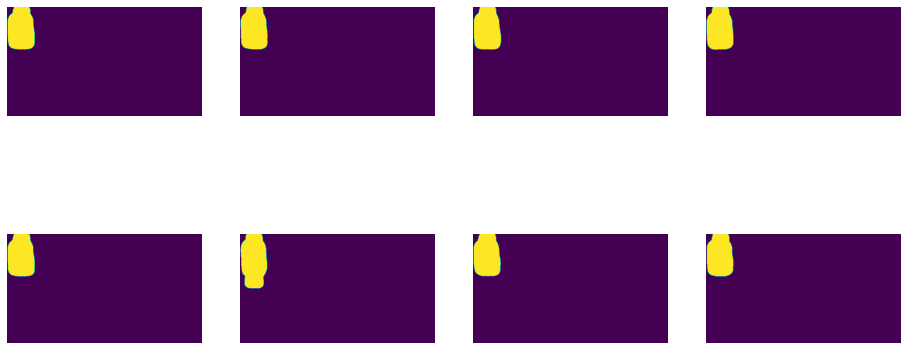

100%|██████████| 2104/2104 [00:34<00:00, 60.49it/s]
I0302 12:34:47.640251 139866521229120 extract_features_masked.py:203] Finished exporting features.


In [17]:
extract_features_masked.main(feature_conf_superpoint_query,path_to_query,output_path,path_to_mask)

In [18]:
## setting the configuration for matches query (superglue)
matcher_conf_query = {'output': 'matches-superglue_query', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features_query = feature_conf_superpoint_query['output']
loc_pairs = output_path/global_file_txt

In [19]:
### this will be differnt 
features = "features_superpoint"

In [20]:
## this matcheer is differnt as it needs feature both for the query imags and map images
from hloc import feature_matcher_map_query
feature_matcher_map_query.main(matcher_conf_query, loc_pairs, features, output_path, features_query)

I0302 12:34:51.767657 139866521229120 feature_matcher_map_query.py:42] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue_query'}
I0302 12:34:51.770205 139866521229120 feature_matcher_map_query.py:50] Using query_features features_superpoint_query_scale_0.35
  0%|          | 2/21040 [00:00<25:26, 13.78it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 21040/21040 [17:24<00:00, 20.14it/s]
I0302 12:52:16.648552 139866521229120 feature_matcher_map_query.py:127] Finished exporting matches.


In [21]:
sfm_dir = output_path/'sfm_superpoint+superglue'
geo_registration_dir = sfm_dir/"geo_registered_model"

In [ ]:
from hloc import localize_sfm

localize_sfm.main(geo_registration_dir,
                 output_path/"queries_choosen_with_intrinsics.txt",
                 loc_pairs,
                 output_path/'features_superpoint_query.h5',
                 output_path/'features_superpoint_matches-superglue_query_global_image_query_scale_0.35.h5',
                 output_path/'results_query.txt',
                 covisibility_clustering=False)

I0302 12:52:16.724024 139866521229120 parsers.py:16] Importing 2104 queries in queries_choosen_with_intrinsics.txt
I0302 12:52:16.754875 139866521229120 localize_sfm.py:109] Reading 3D model...
I0302 12:52:18.476036 139866521229120 localize_sfm.py:123] Starting localization...
 72%|███████▏  | 1510/2104 [34:21<11:41,  1.18s/it] 

In [ ]:
## to visualize tracked points
from hloc import  visualization
local_feature_path = output_path/'features_superpoint.h5'
local_feature_path_query = output_path/'features_superpoint_query.h5'
visualization.visualize_loc_new(
    output_path/'results_query_scale_0.35.txt', path_to_images_for_map,path_to_query,local_feature_path, local_feature_path_query, geo_registration_dir , n=10, top_k_db=1, seed=2)

In [ ]:
## ground truth for query images
names_trans_rot_query = jsonparser.parser("/home/Hierarchical-Localization/datasets/UsefulPosesT4HH")

In [ ]:
len(names_trans_rot_query)

In [ ]:
def file_creator_error(original_dict_json, file_name_read, file_name_write, path):
    list_of_registered = list(original_dict_json.keys())
    with open(path/file_name_read, 'r') as f:
        Lines = f.readlines()
    error_list = []
    with open(path/file_name_write, 'w') as f:
        for line in Lines:
            line = line.split()
            name = line[0]
            qvec = np.asarray(line[1:5], dtype=np.float32)
#             qvec = np.array([line[2], line[3], line[4], line[1]],dtype=np.float32)
            tvec = np.asarray(line[5:8], dtype=np.float32)
            tvec_world = colmap_to_global(tvec, qvec)
            tvec_ori = original_dict_json[name]["tvec"]
            er =  error(tvec_world, tvec_ori)
            error_list.append(er)
            string = name + " "+ str(tvec_ori)+ " "+str(tvec_world)+ " " + str(er)+ "\n"
            f.write(string)
        error_list = np.asarray(error_list,  dtype=np.float32)
        string = "The median error is "+ str(np.median(error_list))+ '\n'
        f.write(string)
        string = "The mean error is "+ str(np.mean(error_list))+ '\n'
        f.write(string)
        string = "The max error is "+ str(np.max(error_list))
        f.write(string)

In [ ]:
file_creator_error(names_trans_rot_query,'results_query.txt', "results_query_error.txt", output_path)